# PyTorch Computer vision

Computer vision is the art of teaching a computer to 'see', for example building a model to classify whether a photo is a cat or a dog.

Where does it get used?
* Camera and photo apps to enhance images
* Modern cars use it for parking and collision detection
* Identifying defects in manufacturing processes
* Security cameras

and the list goes on.

## Computer vision libraries in PyTorch.

* torchvision - contains datasets, model architectures and image transformations
* torchvision.datasets - contains datasets
* torchvision.models - contains well-performing and commonly used computer vision model architectures
* torchvision.transforms -used to transform images 
* torch.utils.data.Dataset - base dataset class for pytorch
* torch.utils.data.Dataloader - Creates an iterable over a data set 

In [5]:
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")
device = "cuda" if torch.cuda.is_available() else "cpu"

PyTorch version: 2.4.0+cu118
torchvision version: 0.19.0+cu118


## Getting a dataset

To begin working on a computer vision problem, we first need a computer vision data set and we will start with FashionMNIST, which contains grey scaled images for 10 different items of clothing.

To get this data set we can use torchvision.datasets(.FashionMNIST()), and to use this we will need the following arguments:
* root : str - which folder to dowload the data to
* train : Bool - do we want the training data?
* dowload : bool - should we dowload it?
* transform : torchvision.transforms - what tranformations do we want on the data?
* target_transform

In [6]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

The shape of the of singular training example is (1, 28, 28) which corresponds to (colour_channel, height, width) - a common shape used for images.

PyTorch generally accepts NCHW (channels first) as the default for many operators, but PyTorch explains that NHWC (channels last) performs bettwen and is considered best practice, for now as our channel size and data is small it won't make a massive difference.

We can also display our image using matplotlibs .imshow(). 

First we have got the label dictionary of classes, so that we can map our number prediction to the piece of clothing, we have then plotted a colour scale and a grey scaled version of the image.

Image shape: torch.Size([1, 28, 28])


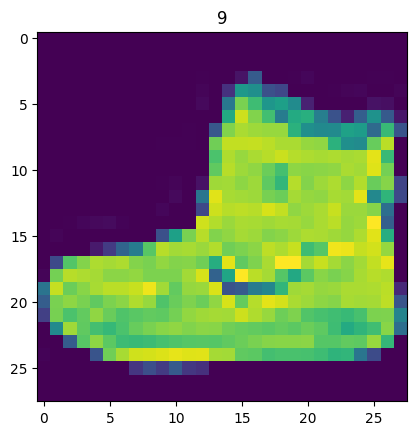

Text(0.5, 1.0, 'Ankle boot')

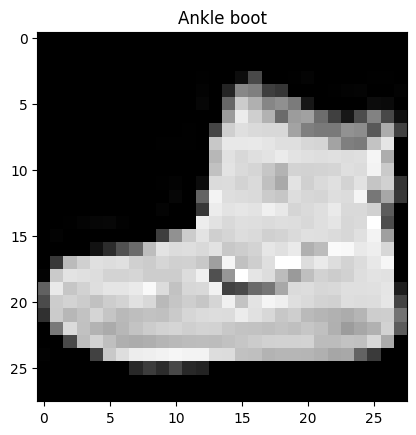

In [7]:
class_names = train_data.classes
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label)
plt.show()

plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

# Prepare data loader

Now that we have got our dataset ready, the next step is to prepare it with a dataloader. A dataloader helps load data into a model in an efficient manner both in terms of speed and memory.

The dataloader turns the data set into smaller iterable chuncks called batches or mini-batches, set by the batch_size paramater.

Batch size is a hyper paramater, so can try all sorts of values, although powers of 2 are used more often.

In [8]:

from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000027B0F0F2900>, <torch.utils.data.dataloader.DataLoader object at 0x0000027B0B325220>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


## Functionising test and train

Before we build and train our model we will functionalise a training and testing step.  

Both functions should take as argugments
* the model 
* the data loader
* the loss function
* accuracy - for showing progression of the training
* device - the device to train/test on.

Our funcitons below are 1 epoch of the training loop, divided into the matches.

In [9]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

## Building our model - convolutional neural network

They did cover 2 more basic models but I didn't really want to go through the whole process again and wanted this notebook to be concise showing how to use CNN's so skipped straight to it.

The CNN model we are going to be using is known as TingVGG from [here](https://poloclub.github.io/cnn-explainer/). I will cover more indepth look at how CNN's work in another notebook. 

TinyVGG follows the typical structure of a CNN of 

Input layer -> [Convolutional layer -> Activation layer -> pooling layer] -> output layer

where the convolution -> pool layer can be repeated a number of times as needed.

The model shown on the link above it produced in the code below.

In [10]:
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape : int , hidden_units : int, output_shape : int) -> None:
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1       
                    ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1, # Default
                      padding = 1       
                    ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2) # The default stride is same size as kernal can just do (2) here which is the same
            )
        self.block2 = nn.Sequential(

            nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        # print(x.shape)
        x = self.block2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModel(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

        

FashionMNISTModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

There is a bunch of stuff about how Conv2d and Maxpool2d work but I will cover that when I take a deep dive through CNN's in general.

We now need to go through the process, and the next is setting our loss and optimiser function.

In [11]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss() # Multiclass classification problem
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1) # Create our optimisier over our models paramaters and with a loss rate

Next we need to create a training and testing loop, and to do that we will utilise our test and train step functions.

In [12]:
from helper_functions import accuracy_fn
from tqdm.auto import tqdm
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

c:\Users\jackg\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59582 | Train accuracy: 78.43%


 33%|███▎      | 1/3 [00:12<00:25, 12.74s/it]

Test loss: 0.41553 | Test accuracy: 85.20%

Epoch: 1
---------
Train loss: 0.36031 | Train accuracy: 87.11%


 67%|██████▋   | 2/3 [00:25<00:12, 12.55s/it]

Test loss: 0.36103 | Test accuracy: 86.71%

Epoch: 2
---------
Train loss: 0.32268 | Train accuracy: 88.27%


100%|██████████| 3/3 [00:37<00:00, 12.58s/it]

Test loss: 0.31994 | Test accuracy: 88.49%

Train time on cuda: 37.749 seconds


We see that each loop of the training takes roughly the same amount of time to train, and that each time our test accuracy slighty increases.

## Performance - speed trade off

We could obviously increase the number of epoches we train our model for in order to increase accuarcy but at some point the increased training time is not worth the marginal performance, this is also true between simpler models and more complex models.

A massive part of building and deciding on the model is about picking a good trade of between performance and training time and model readability.

## Model metrics and Confusion matrix

For classification problems, there are a number of different metrics that we can use to evaluate our model, one of the most visual is the confusion matrix.

The confusion matrix shows where the classification model got 'confused' between predictions and true labels.

We will make our confusion matrix by
* making predictions with the trained model
* Make a confusion matrix with torchmetrics.ConfusionMatrix
* Plot the confusion matrix using mlxtend.plotting.plot_confusion_matrix().

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 237.67it/s]


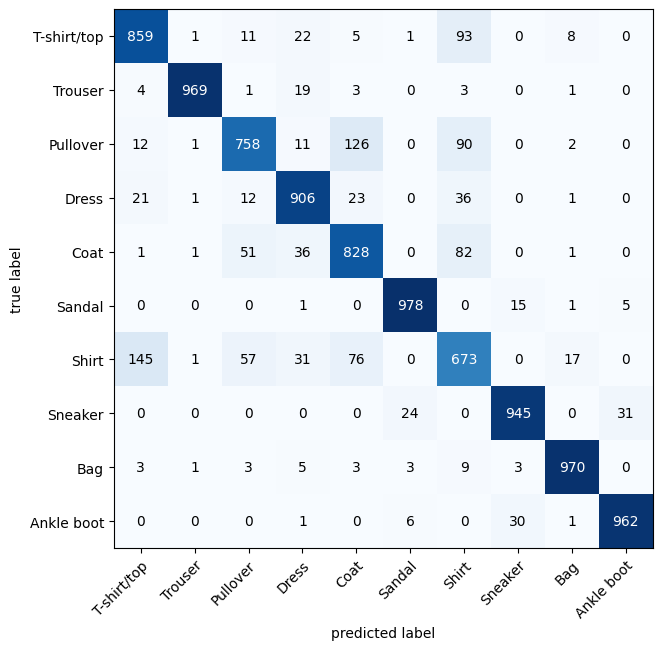

In [13]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
)